In [1]:
import re
import os
import math
import json
import igraph

import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

from time import time
from pprint import pprint
from random import sample

from itertools import groupby
from itertools import combinations

from collections import defaultdict

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.datasets.base import Bunch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering

from networkx.readwrite import json_graph

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
def abs_dist(attr='price'):
    def _inner(a, b):
        return abs(a[attr] - b[attr])
    return _inner

In [3]:
def equal_dist(attr='name'):
    def _inner(a, b):
        if a[attr] == b[attr]:
            return 0.0
        else:
            return 1.0
    return _inner

In [4]:
class Distance:
    distances = [
        abs_dist(attr='price'),
        equal_dist(attr='name'),
    ]
    def __call__(self, a, b):
        distances = []
        for distance in self.distances:
            distances.append(distance(a, b))
        return np.array(distances)

## clean up prices

In [5]:
def convert_price(price):
    price = str(price)
    if ',' in price:
        if '.' in price:
            price = price.replace('.', '')
        price = price.replace(',', '.')
        
    if ' EUR' in price:
        price = price.replace(' EUR', '')

    try:
        return float(price)
    except ValueError:
        # print('<{}>'.format(price))
        return None

## read products feed

In [6]:
products = pd.read_csv('products.csv', error_bad_lines=False, converters={'price': convert_price})
products = products.drop('Unnamed: 0', 1)
products = products[~products.price.isnull()]
list(products.columns)

//anaconda/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (1,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['privateid',
 'name',
 'shortdescription',
 'brand',
 'ean',
 'price',
 'type',
 'shop']

In [7]:
products.shape

(384546, 8)

## group by ean and get samples with at least 5 items

In [9]:
# dunno why this is so slow
# ean_grouped = products.groupby('ean').filter(lambda x: len(x) > 5)

In [10]:
# select only eans which appear in more than 5 shops
shops_for_ean = defaultdict(set)
for ean, shop in zip(products.ean, products.shop):
    shops_for_ean[ean].add(shop)
good_eans = list({ean for ean, shops in shops_for_ean.items() if len(shops) > 5})
#sample_products = products[products.ean.isin(pd.Series(list(good_eans)).sample(n=10))]
#sample_eans = sorted(good_eans)[380:390]
sample_eans = sample(good_eans, 10)
sample_products = products[products.ean.isin(pd.Series(sample_eans))]
#sample_products = products[products.ean.isin(pd.Series(list(good_eans)))]
#print(sample_products.shape)

## create sample dataset

In [11]:
dataset = Bunch()
dataset.data = sample_products
dataset.target = sample_products.ean
dataset.true_k = np.unique(dataset.target).shape[0]

In [12]:
dataset.data[['shop', 'ean', 'name', 'brand', 'type', 'price']].sort(['ean'])

//anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,shop,ean,name,brand,type,price
299245,3402,23942440130,MICROSDHC 32GB - CLASS 10,Verbatim,Speichermedien / Portabel (Secure Digital Cards),15.50
272505,2782,23942440130,microSDHC 32GB Verbatim Class 10,Verbatim,Speicherkarten,13.59
274711,2784,23942440130,InLine® Kabeldurchführung PG 25 Nylon IP,inLine,"Installation, Reinigung",11.53
274712,2784,23942440130,microSDHC 32GB Verbatim Class 10,Verbatim,Speicherkarten,13.59
251193,1858,23942440130,Verbatim microSDHC 32GB Class 10 -bei bücher.d...,Verbatim,"Elektronik, Foto & Optik > Kamera & Foto > Kam...",13.99
281194,3033,23942440130,"Verbatim microSDHC-Karte, Klasse 10, 32 GB",Verbatim,Computer & Software > PCs > Komponenten > Gehä...,22.00
262004,2334,23942440130,Verbatim MicroSDHC Card 32 GB (class 10),VERBATIM,"Elektronik, Foto & Optik > Kamera & Foto > Kam...",26.07
235491,1567,23942440130,Verbatim SD MicroSD Card 32GB Verbatim Class10,Verbatim,Computer & Software > PC Zubehör,18.71
272504,2782,23942440130,InLine® Kabeldurchführung PG 25 Nylon IP,inLine,"Installation, Reinigung",11.53
313703,3790,23942440130,MICRO SDHC CARD 32GB CLASS10,Verbatim,IT Katalog 1 > Speichermedien > Portable Speic...,25.95


## feature extraction

In [13]:
class EmptyFitMixin:
    def fit(self, x, y=None):
        return self

In [14]:
class ItemSelector(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def __init__(self, key):
        self.key = key

    def transform(self, df):
        values = np.array(df[self.key])
        return values.reshape(values.shape[0], 1)

In [15]:
class TextExtractor(BaseEstimator, TransformerMixin, EmptyFitMixin):
    """Extract the text from a product in a single pass.

    Takes a pandas dataframe and produces a series of texts
    from joined columns defined in `text_cols`.
    """
    def __init__(self, text_cols=['name', 'shortdescription', 'brand', 'type']):
        self.text_cols = text_cols
    
    def transform(self, data):
        def join(items):
            return ' '.join([str(item) for item in items])
        
        texts = data[self.text_cols].apply(join, axis=1)
        return texts

In [16]:
class WhitespaceRemover(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def __init__(self, regex='[^0-9a-zA-Z]+'):
        self.regex = re.compile(regex)
        
    def transform(self, data):
        return (self.regex.sub('', row) for row in data)        

In [17]:
class CosineDistance(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        cosine_similarity = linear_kernel(X, X)
        return 1.0 - cosine_similarity

In [18]:
class NumericDistance(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        return manhattan_distances(X)

In [19]:
class CombineDistances(BaseEstimator, TransformerMixin, EmptyFitMixin):
    def transform(self, X):
        parts_num = X.shape[1] / X.shape[0]
        parts = np.split(X, parts_num, axis=1)
        # combine with euclidean distance
        return np.sqrt(np.sum(p**2 for p in parts))

In [20]:
simple_features = FeatureUnion(
    transformer_list=[

        # Pipeline for pulling features from the text columns
        ('text_tfidf', Pipeline([
            # Extract text data from products
            ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
            ('tfidf', TfidfVectorizer()),
            ('svd', TruncatedSVD(2)),
            ('normalizer', Normalizer(copy=False)),
        ])),

        # Pipeline for price
        ('price', Pipeline([
            ('selector', ItemSelector(key='price')),
        ])),
    ],
)

In [21]:
pipeline_simple = Pipeline([
    # Use FeatureUnion to extract features from text and price
    ('features', simple_features),
    # Use kmeans clustering on the combined features
    ('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [22]:
#pp = sns.pairplot(sproducts, hue="ean", vars=['text_1', 'text_2', 'price'])

In [23]:
distance_features = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            # Pipeline for pulling features from the text columns
            # and build a cosine distance matrix from it
            ('text_tfidf', Pipeline([
                ('text', TextExtractor(text_cols=['name', 'brand', 'type'])),
                ('tfidf', TfidfVectorizer()),
                ('tfidf_distance', CosineDistance()),
            ])),
                    
            # Pipeline for pulling ngram features from the name column
            ('ngram_tfidf', Pipeline([
                ('text', TextExtractor(text_cols=['name'])),
                ('whitespace_remove', WhitespaceRemover()),
                ('tfidf', TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5))),
                ('tfidf_distance', CosineDistance()),
            ])),

            # Pipeline for price
            ('price', Pipeline([
                ('selector', ItemSelector(key='price')),
                ('price_distance', NumericDistance()),
                ('normalizer', Normalizer(copy=False)),
            ])),
        ],
    )),
    ('combine', CombineDistances()),
])

In [24]:
pipeline_distances = Pipeline([
    # Use FeatureUnion to combine the features from text and price
    ('distances', distance_features),
    # Use kmeans clustering on the combined features
    ('kmeans', KMeans(n_clusters=dataset.true_k, init='k-means++', max_iter=100, n_init=1)),
])

In [25]:
#X = pipeline_distances.transform(dataset.data)
#pp = sns.pairplot(sproducts, hue="ean", vars=['text_1', 'text_2', 'price'])

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


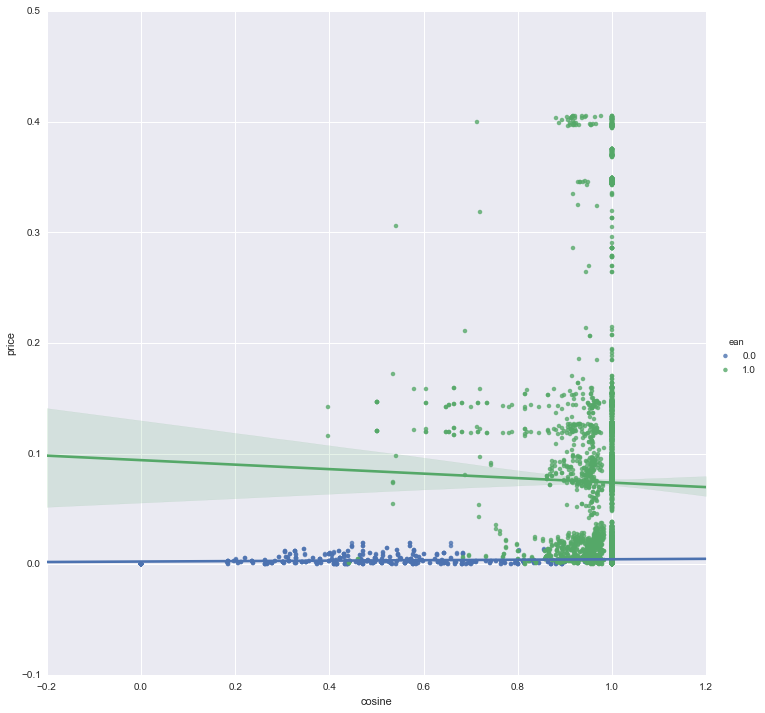

In [26]:
X_cosine_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[0][1].fit_transform(dataset.data).flatten()
X_ngram_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[1][1].fit_transform(dataset.data).flatten()
X_price_dist = pipeline_distances.steps[0][1].steps[0][1].transformer_list[2][1].transform(dataset.data).flatten()
X_ean_dist = NumericDistance().transform(ItemSelector(key='ean').transform(dataset.data)).flatten()
X_ean_dist[X_ean_dist > 0] = 1
df = pd.DataFrame({'cosine': X_cosine_dist, 'price': X_price_dist, 'ngram': X_ngram_dist, 'ean': X_ean_dist})
#pp = sns.pairplot(df, hue="ean", vars=['cosine', 'price'], diag_kind="kde")
#sns.jointplot("cosine", "price", data=df, kind='scatter', size=10);
#sns.pairplot(df, x_vars=["cosine"], y_vars=["price"], hue="ean", size=10, kind="scatter")
sns.lmplot(x="cosine", y="price", hue="ean", data=df, size=10) # good

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


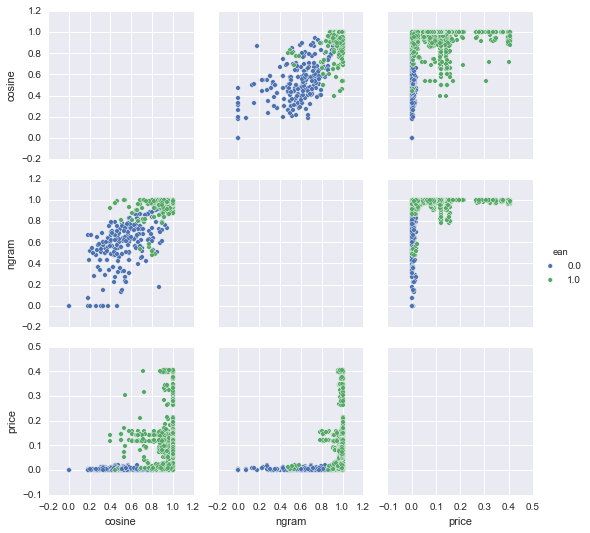

In [27]:
pp = sns.pairplot(df, hue="ean", vars=['cosine', 'ngram', 'price'], diag_kind="reg")

In [27]:
X_ngram_dist

array([ -1.99840144e-15,  -1.99840144e-15,  -1.99840144e-15, ...,
         9.86838385e-01,   9.81969769e-01,   3.33066907e-16])

In [28]:
def match_kdeplot(df):
    sns.set(style="darkgrid")

    pos_cosine = df['cosine'][df['ean'] == 0]
    pos_price = df['price'][df['ean'] == 0]
    neg_cosine = df['cosine'][df['ean'] == 1]
    neg_cosine = neg_cosine[neg_cosine < 0.98]
    neg_price = df['price'][df['ean'] == 1]
    neg_price = neg_price[neg_price < 0.2][:neg_cosine.shape[0]]

    # Set up the figure
    f, ax = plt.subplots(figsize=(12, 10))
    #ax.set_aspect("equal")

    # Draw the two density plots
    ax = sns.kdeplot(pos_cosine, pos_price, cmap="Reds", shade=True, shade_lowest=False)
    ax = sns.kdeplot(neg_cosine, neg_price, cmap="Blues", shade=True, shade_lowest=False)

    # Add labels to the plot
    red = sns.color_palette("Reds")[-2]
    blue = sns.color_palette("Blues")[-2]
    ax.text(0.1, 0.02, "match", size=16, color=red)
    ax.text(0.6, 0.075, "non-match", size=16, color=blue)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


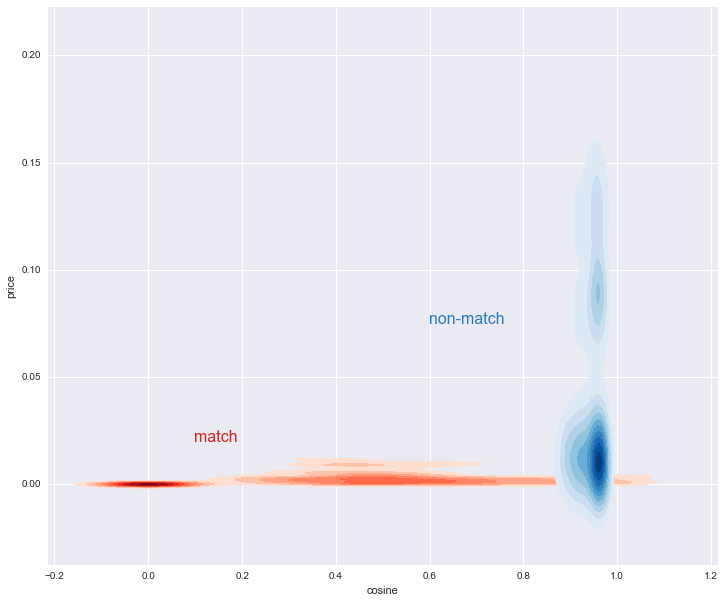

In [29]:
match_kdeplot(df)

In [30]:
pipeline_dbscan = Pipeline([
    # Use FeatureUnion to combine the features from text and price
    ('distances', distance_features),
    # Use kmeans clustering on the combined features
    ('dbscan', DBSCAN(eps=0.3, min_samples=3)),
    #('dbscan', SpectralClustering(n_clusters=dataset.true_k, eigen_solver='arpack')),
])

In [31]:
class Evaluation: 
    def __init__(self, pipeline, dataset):
        pipeline.fit(dataset.data)
        self.X = None
        try:
            self.X = pipeline.transform(dataset.data)
        except AttributeError as e:
            pass
        self.predicted = pipeline.predict(dataset.data)
            
        self.dataset = dataset
        
    def pairwise(self):
        """
        Takes two iterables of true and predicted labels and calculates
        the pairwise matches for each of them. For n samples there are
        n**2 pairs. Each pair is either a match or not. We are comparing
        the set of true matches/non-matches vs the set of the predicted
        matches/non-matches by treating them as results of a binary
        classification task and print out a classification report.
        """
        
        def all_combinations(ids):
            for a in ids:
                for b in ids:
                    yield a, b

        def matches_from_labels(labels):
            num = len(labels)
            pairwise = np.zeros(num ** 2).reshape(num, num)
            clusters = defaultdict(list)
            for idx, p in enumerate(labels):
                clusters[p].append(idx)
            for cluster in clusters.values():
                for i, j in all_combinations(cluster):
                    pairwise[i, j] = 1
            return pairwise.flatten()
    
        predicted_pairwise = matches_from_labels(self.predicted)
        true_pairwise = matches_from_labels(self.dataset.target)
        print(classification_report(true_pairwise, predicted_pairwise))
                
    def scores(self):
        """
        Just the usual suspects.
        """
        true, predicted = self.dataset.target, self.predicted
        print("Homogeneity: %0.3f" % metrics.homogeneity_score(true, predicted))
        print("Completeness: %0.3f" % metrics.completeness_score(true, predicted))
        print("V-measure: %0.3f" % metrics.v_measure_score(true, predicted))
        print("Adjusted Rand-Index: %.3f"
              % metrics.adjusted_rand_score(true, predicted))
        if self.X is not None:
            print("Silhouette Coefficient: %0.3f"
                  % metrics.silhouette_score(self.X, predicted, sample_size=1000))
            
    def show_clusters(self):
        dataset = self.dataset
        true, predicted = self.dataset.target, self.predicted
        ean_clusters = defaultdict(list)
        predicted_clusters = defaultdict(list)
        for target, label, (_ix, row) in zip(true, predicted, dataset.data.iterrows()):
            ean_clusters[label].append(row)
            predicted_clusters[label].append(row)
        for label, cluster in predicted_clusters.items():
            pprint([r['name'] for r in cluster])
        for label, cluster in ean_clusters.items():
            pprint([r['name'] for r in cluster])
            
    def confusion_matrix(self):
        dataset = self.dataset
        true, predicted = self.dataset.target, self.predicted
        for _ix, row in dataset.data.iterrows():
            # decide wether it's tp, tn, fp, fn
            print(_ix)

In [32]:
#%timeit pipeline_simple.fit_predict(dataset.data)

In [33]:
evaluate_simple = Evaluation(pipeline_simple, dataset)
evaluate_simple.pairwise()
evaluate_simple.scores()

             precision    recall  f1-score   support

        0.0       0.97      0.90      0.93      5294
        1.0       0.47      0.74      0.58       635

avg / total       0.91      0.88      0.89      5929

Homogeneity: 0.696
Completeness: 0.800
V-measure: 0.744
Adjusted Rand-Index: 0.468
Silhouette Coefficient: 0.604


//anaconda/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [34]:
evaluate_distances = Evaluation(pipeline_distances, dataset)
evaluate_distances.pairwise()
evaluate_distances.scores()

             precision    recall  f1-score   support

        0.0       0.99      0.98      0.99      5294
        1.0       0.88      0.94      0.91       635

avg / total       0.98      0.98      0.98      5929

Homogeneity: 0.949
Completeness: 0.970
V-measure: 0.959
Adjusted Rand-Index: 0.886
Silhouette Coefficient: 0.745


In [126]:
#evaluate_distances.confusion_matrix()

In [127]:
#evaluate_distances.show_clusters()

## distances to graph

In [35]:
# calc distances
X = distance_features.fit_transform(dataset.data, dataset.target)

In [36]:
# convert distance matrix to graph
dt = [('distance', float)]
G = nx.from_numpy_matrix(X.view(dt))

In [37]:
# create node color lookup dict
eans = set(dataset.data.ean)
colors = [int(c.replace('#', '0x'), 16) for c in sns.color_palette("hls", len(eans)).as_hex()]
ean_colors = {e: c for e, c in zip(eans, colors)}
node_colors = dict(enumerate((ean_colors[ean] for ean in dataset.data.ean)))

## visualize distance graph with igraph and webgl

In [38]:
# create json representation of graph, reformat node format and add color to nodes
igraph_json = json_graph.node_link_data(G)
igraph_json['nodes'] = {n['id']: {'id': n['id'], 'color': node_colors[n['id']]} for n in igraph_json['nodes']}
# reduce number of edges and rename links to edges
#igraph_json['edges'] = [l for l in igraph_json['links'] if l['distance'] < 1.0 and l['distance'] > 0.1]
igraph_json['edges'] = [l for l in igraph_json['links'] if l['distance'] < 1.1 and l['distance'] > 0.0]
len(igraph_json['edges'])

334

In [39]:
igraph.draw(igraph_json, size=(800, 600), directed=False)

//anaconda/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## visualize distance graph with d3 and svg

In [40]:
# create json representation of graph, reformat node format and add color to nodes
d3_graph_json = json_graph.node_link_data(G)
d3_graph_json['nodes'] = [{'id': n['id'], 'color': node_colors[n['id']]} for n in d3_graph_json['nodes']]
pprint(d3_graph_json['nodes'][:2])
# filter links
d3_graph_json['links'] = [l for l in d3_graph_json['links'] if l['distance'] < 1.1 and l['distance'] > 0.0]
pprint(d3_graph_json['links'][:2])

# python json to javascript
from IPython.display import Javascript
#runs arbitrary javascript, client-side
Javascript("window.graph_json={};".format(json.dumps(d3_graph_json)))

[{'color': 14374814, 'id': 0}, {'color': 13195227, 'id': 1}]
[{'distance': 2.0014830212433605e-15, 'source': 0, 'target': 0},
 {'distance': 0.8770096457457421, 'source': 0, 'target': 4}]


<IPython.core.display.Javascript object>

In [41]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [42]:
%%javascript
require(['d3'], function(d3){
  //a weird idempotency thing
  $("#chart1").remove();
  //create canvas
  var style = [
    '<style>',
    '.node {',
    '  stroke: #fff;',
    '  stroke-width: 1.5px;',
    '}',
    '.link {',
    '  stroke: #999;',
    '  stroke-opacity: .6;',
    '}',
    'h3 {',
    '  color: #1ABC9C;',
    '  text-align:center;',
    '  font-style: italic;',
    '  font-size: 14px;',
    '  font-family: "Helvetica";',
    '}',
    'thresholdSlider {',
    '  width: 10%;',
    '}',
    '</style>'
  ].join('\n');
    
  var threshold_form = [
    '<form>',
    '  <h3>',
    '    <input type="range" id="thresholdSlider" name="points" value="0.0" min="0" max="120" onchange="window.threshold(this.value)">',
    '  </h3>',
    '</form>',
  ].join('\n')

  element.append(style);
  element.append("<h1>distance graph</h1>")
  element.append(threshold_form);
  element.append("<div id='chart1'></div>");

  var graph = window.graph_json;
  var graphRec = JSON.parse(JSON.stringify(graph));

  function restart() {
    link = link.data(graph.links);
    link.exit().remove();
    link.enter().insert("line", ".node").attr("class", "link");
    node = node.data(graph.nodes);
    node.enter().insert("circle", ".cursor").attr("class", "node").attr("r", 5).call(force.drag);
    force.start();
  };        
        
  function threshold(thresh) {
    console.log('raw threshold: ' + thresh);
    if (thresh > 0) {
        thresh = 0.01 * thresh;
    }
    console.log('threshold: ' + thresh);
    //var threshold_element = d3.select("#foobar");
    //threshold_element.text = thresh;
    graph.links.splice(0, graph.links.length);

    for (var i = 0; i < graphRec.links.length; i++) {
      if (graphRec.links[i].distance > thresh) {graph.links.push(graphRec.links[i]);}
    }
    restart();
  };
        
  window.threshold = threshold;
        
  var width = 960,
    height = 500;

  var color = d3.scale.category20();

  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  var svg = d3.select("#chart1").append("svg")
    .attr("width", width)
    .attr("height", height);

  force
    .nodes(graph.nodes)
    .links(graph.links)
    .start();

  var link = svg.selectAll(".link")
    .data(graph.links)
  .enter().append("line")
    .attr("class", "link")
    .style("stroke", "#999")
    .style("stroke-width", function(d) { return 1.0; });
//    .style("stroke-width", function(d) { return d.distance / 1.0; });

  var node = svg.selectAll(".node")
    .data(graph.nodes)
  .enter().append("circle")
    .attr("class", "node")
    .attr("r", 5)
    .style("fill", function(d) { return color(d.color); })
    .call(force.drag);

  node.append("title")
    .text(function(d) { return d.id; });

  force.on("tick", function() {
    link.attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node.attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
  });
});

<IPython.core.display.Javascript object>

## manual distance calculations

In [528]:
distance = Distance()
distances = []
for a, b in combinations(dataset.data, 2):
    pass
    #distances.append(distance(a, b))
len(distances)

0

In [102]:
dataset.data.ean.iloc[1]

2998949374840